In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import  preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def score_pred(model, X, text):
    pred = model.predict(X)
    score = np.sqrt(mean_squared_error(pred,X))
    print(f"{text} (RMSE): {score}")
    return pred
    
def standardization_by_duration(matrix, duration_fraction):
    # duration = 10s 
    # duration fraction = 0.2
    # sample time = duration * param time
    # bits per second = 10 bps
    # In 10s there are 100bps

    # 20%´s duration is 2s, in that time there would 2bps
    # To standarize the values in relation to the duration
    # the equation should be: (bits per second)bps * (sample time)s /(duration)s

    duration = matrix[:,0] 
    sample_time = duration * duration_fraction
    standarized_matrix = (matrix * sample_time[:,None]) / duration[:,None]
    
    standarized_matrix[:,0]  = sample_time
    return standarized_matrix

In [4]:
mainpath="../NSL-KDD/"
transformed_datasets_folder = "transformed_datasets/"
tuned_complete_traffic = "complete_trafic_retocado.csv"
file_anomaly_traffic = "anomaly_traffic.csv"
model_path = "../anomaly_model"

csv_tuned_traffic_path = mainpath + transformed_datasets_folder + tuned_complete_traffic

In [5]:
df_tuned_traffic = pd.read_csv(csv_tuned_traffic_path)
df_tuned_traffic.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
np_array = df_tuned_traffic.to_numpy()
#np_array = np.random.shuffle(np_array)
class_label = np_array[:, -1] # for last column
data = np_array[:, :-1] # for all but last column
data = preprocessing.normalize(data,norm='l2')

In [7]:
model = load_model(model_path)
pred = model.predict(standardization_by_duration(data, 0.8))

In [8]:
square_diff = np.square( data - pred)
rmse_values = np.sqrt(square_diff.mean(axis=1))
print(rmse_values)

[0.06368987 0.0284185  0.0369994  ... 0.04405494 0.01970106 0.04263338]


In [9]:
tmp_arr = np.where((rmse_values >= 0.040), 1, rmse_values)
predicted_class_label = np.where( rmse_values < 0.040, 0, tmp_arr)
print(predicted_class_label)
print(class_label)

[1. 0. 0. ... 1. 0. 1.]
[0. 0. 0. ... 1. 0. 1.]


In [10]:
X_samples = standardization_by_duration(data, 0.8)
X_sample_normal = X_samples[1]
X_sample_anomaly = X_samples[-1]

In [16]:
pred_sample = model.predict( np.array( [X_sample_normal,] )) 
score_sample = np.sqrt(mean_squared_error(pred_sample, np.array( [X_sample_normal,])))
print(f"Ejemplo de una muestra de tráfico normal (RMSE): {score_sample}\n")
print(df_tuned_traffic.loc[1])

Ejemplo de una muestra de tráfico normal (RMSE): 0.038830720628689086

duration                         507.00
protocol_type                      1.00
service                           60.00
flag                               9.00
src_bytes                        437.00
dst_bytes                      14421.00
land                               0.00
wrong_fragment                     0.00
urgent                             0.00
hot                                0.00
num_failed_logins                  0.00
logged_in                          1.00
num_compromised                    3.00
root_shell                         0.00
su_attempted                       0.00
num_root                           0.00
num_file_creations                 0.00
num_shells                         0.00
num_access_files                   1.00
num_outbound_cmds                  0.00
is_host_login                      0.00
is_guest_login                     0.00
count                              1.00
srv_count

In [17]:
pred_sample = model.predict( np.array( [X_sample_anomaly,] )) 
score_sample = np.sqrt(mean_squared_error(pred_sample, np.array( [X_sample_anomaly,])))
print(f"Ejemplo de una muestra de tráfico anomalo (RMSE): {score_sample}\n")
print(df_tuned_traffic.iloc[-1])

Ejemplo de una muestra de tráfico anomalo (RMSE): 0.0429349520338451

duration                         0.90
protocol_type                    1.00
service                         57.00
flag                             1.00
src_bytes                        0.00
dst_bytes                        0.00
land                             0.00
wrong_fragment                   0.00
urgent                           0.00
hot                              0.00
num_failed_logins                0.00
logged_in                        0.00
num_compromised                  0.00
root_shell                       0.00
su_attempted                     0.00
num_root                         0.00
num_file_creations               0.00
num_shells                       0.00
num_access_files                 0.00
num_outbound_cmds                0.00
is_host_login                    0.00
is_guest_login                   0.00
count                            4.00
srv_count                       10.00
serror_rate       

In [13]:
cf_matrix = confusion_matrix(class_label, predicted_class_label)
print(cf_matrix)
tn, fp, fn, tp = confusion_matrix(class_label, predicted_class_label).ravel()
print(tn, fp, fn, tp)

[[68084  8970]
 [10011 61452]]
68084 8970 10011 61452


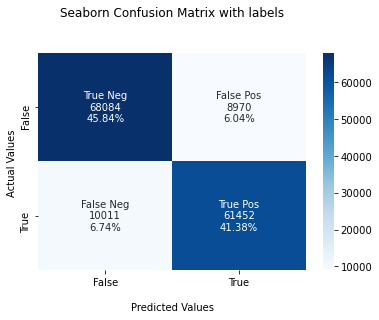

In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [15]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(class_label, predicted_class_label)
print("Accuracy Test sample: %.1f%%" % (100.0 * accuracy))

# precision tp / (tp + fp)
precision = precision_score(class_label, predicted_class_label)
print("Precision Test sample: %.1f%%" % (100.0 * precision))

# recall: tp / (tp + fn)
recall = recall_score(class_label, predicted_class_label)
print("Recall Test sample: %.1f%%" % (100.0 * recall))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(class_label, predicted_class_label)
print("F1 score Test sample: %.1f%%" % (100.0 * f1))

Accuracy Test sample: 87.2%
Precision Test sample: 87.3%
Recall Test sample: 86.0%
F1 score Test sample: 86.6%
